In [1]:
import requests
from bs4 import BeautifulSoup
import sqlite3
import re
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [2]:
from bs4 import BeautifulSoup
import re
from uuid import uuid4

In [3]:
class Crawler:

    def get_html(self):
        pass

    def get_card_info(self):
        pass

    def get_links(self, page):
        pass

In [44]:
class CrawlerEda(Crawler):

    def get_html(self, page):
        chrome_options = Options()
        chrome_options.add_argument("--disable-extensions")
        chrome_options.add_argument("--disable-popup-blocking")

        browser = webdriver.Chrome(options=chrome_options)
        url = f"https://eda.ru/recepty?page={page}"
        #browser.implicitly_wait(30)
        browser.get(url)
        wait = WebDriverWait(browser, 10)
        soup = BeautifulSoup(browser.page_source, 'html.parser')
        return soup

    def get_card_info(self, number):
        chrome_options = Options()
        chrome_options.add_argument("--disable-extensions")
        chrome_options.add_argument("--disable-popup-blocking")

        browser = webdriver.Chrome(options=chrome_options)
        action = ActionChains(browser)
        count = 0

        #linker = linkers[number]['link']
        #browser.get(linker)
        wait = WebDriverWait(browser, 10)
        soup_card = BeautifulSoup(browser.page_source, 'html.parser')
        return soup_card

    def get_links(self,first_page, last_page):
        links = []
        for i in range(first_page, last_page):
            html = CrawlerEda().get_html(i)
            links.extend(ParserEda(html).get_cards())
            #print(links)
        return links

In [5]:
class Parser:

    def __init__(self, html):
        self.html = html

    def get_cards(self):
        pass

In [43]:
class ParserEda(Parser):

    def get_cards(self):
        linkers = []
        for recipe in self.html.findAll('div', class_='emotion-1f6ych6'):
            try:
                link = "https://eda.ru"+recipe.find('a', class_='emotion-12sjte8').get('href')
                photo = str(recipe.find('img', class_='emotion-1bi124x').get('src')).replace('c180x180', 'c500x500')
                #print(link)
                #print(photo)
                linkers.append(Link(re.findall(r'\b\d+\b', link)[0], link, photo))
            except AttributeError:
                print("There's no item with that code")
        #print(len(linkers))
        return linkers


In [7]:
class Recipe:
    def __init__(self, key, name_dish, count_portion, cook_time, ingredients, manual):
        self.id = key
        self.name_dish = name_dish
        self.count_portion = count_portion
        self.cook_time = cook_time
        self.ingredients = ingredients
        self.manual = manual

In [8]:
class Ingredient:
    def __init__(self, key, name_ingr):
        self.id = key
        self.name_ingr = name_ingr

In [9]:
class Calories:
    def __init__(self, key, calories, proteins, fats, carbohydrates):
        self.id = key
        self.calories = calories
        self.proteins = proteins
        self.fats = fats
        self.carbohydrates = carbohydrates

In [10]:
class Link:
    def __init__(self, key, link, photo):
        self.id = key
        self.link = link
        self.photo = photo

In [46]:
class DBHelper:

    def __init__(self, db_name = "recipe.db"):
        self.dbname = f"sqlite3:/{db_name}"
        self.conn = sqlite3.connect(db_name)

    def simple_create_table(self, table_name, primary_key, params):
        column = ""
        for i in range(len(params) - 1):
            column = str(params[i]) + " TEXT, "
        column += str(params[len(params) - 1]) + " TEXT "
        new_table = f"CREATE TABLE IF NOT EXISTS {table_name} ({primary_key} TEXT PRIMARY KEY , {column})"
        self.conn.execute(new_table)
        self.conn.commit()

    def create_table(self, table_name, primary_key, foreign_table_name, foreign_col, another_foreign_col, params):
        column = ""
        for i in len(params) - 1:
            column += params[i] + " TEXT, "
        column += params[len(params)] + " TEXT "

        foreign_key = f"FOREIGN KEY ({foreign_col})  REFERENCES {foreign_table_name} ({another_foreign_col})"

        new_table = f"CREATE TABLE IF NOT EXISTS {table_name} ({primary_key} TEXT PRIMARY KEY , {column}, {foreign_key})"
        self.conn.execute(new_table)
        self.conn.commit()

    def insert(self, table_name, primary_key, args):
        arguments = "'"
        for i in range(len(args) - 1):
            arguments += args[i] + "', '"
        arguments += args[len(args) - 1] + "'"
        #print(arguments)

        new_insert = f"INSERT INTO {table_name} SELECT * FROM (SELECT {arguments}) AS tmp " \
                     f"WHERE NOT EXISTS ( SELECT {primary_key} FROM {table_name} WHERE {primary_key} = '{args[0]}'" \
                     f") LIMIT 1"
        self.conn.execute(new_insert)
        self.conn.commit()

    def print_info(self, table_name):
        new_get = f"SELECT * FROM {table_name}"
        cursor = self.conn.execute(new_get)
        return [row[0] for row in cursor]

    #def update(self, flat_id, updates):


    #def delete(self, flat_id):


In [12]:
linkers = CrawlerEda().get_links(5)
print(len(linkers))
for i in linkers:
    print(i.id, i.link, i.photo)

TypeError: object of type 'NoneType' has no len()

In [13]:
DBHelper("recipe.db").simple_create_table("link", "id", ["link", "photo"])

In [33]:
DBHelper("recipe.db").print_info("link")

['20955',
 '18506',
 '17614',
 '21916',
 '31799',
 '16014',
 '18811',
 '21751',
 '16922',
 '15574',
 '19334',
 '16149',
 '32614',
 '28425',
 '21506',
 '25902',
 '30600',
 '29566',
 '30625',
 '31193',
 '32534',
 '16754',
 '17889',
 '17620',
 '33916',
 '19945',
 '25076',
 '29574']

210
'48152', 'https://eda.ru/recepty/vypechka-deserty/vjerzere-pirogi-s-kapustoj-48152', 'https://eda.ru/img/eda/c500x500/s1.eda.ru/StaticContent/Photos/160105153525/160114234817/p_O.jpg'
'50133', 'https://eda.ru/recepty/osnovnye-blyuda/perlovaja-kasha-v-multivarke-50133', 'https://eda.ru/img/eda/c500x500/s1.eda.ru/StaticContent/Photos/150412162041/150417221759/p_O.jpg'
'28446', 'https://eda.ru/recepty/osnovnye-blyuda/kotleti-iz-schuki-28446', 'https://eda.ru/img/eda/c500x500/s1.eda.ru/StaticContent/Photos/170306185211/210224120421/p_O.jpg'
'92896', 'https://eda.ru/recepty/osnovnye-blyuda/kotleta-iz-nuta-92896', 'https://eda.ru/img/eda/c500x500/s1.eda.ru/StaticContent/Photos/120131082242/170420181630/p_O.jpg'
'36631', 'https://eda.ru/recepty/supy/sup-s-lososem-i-bolgarskim-percem-36631', 'https://eda.ru/img/eda/c500x500/s1.eda.ru/StaticContent/Photos/i/130328153556/p_O.jpg'
'38272', 'https://eda.ru/recepty/supy/sup-iz-lobio-38272', 'https://eda.ru/img/eda/c500x500/s1.eda.ru/StaticConte
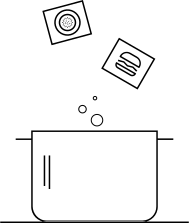
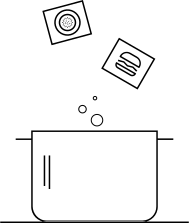
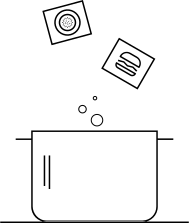
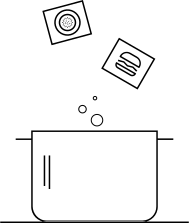
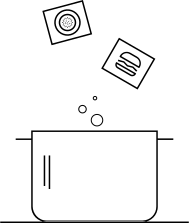
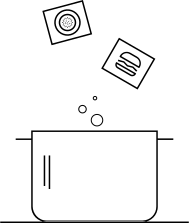
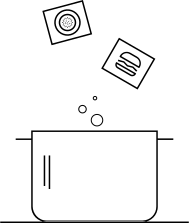
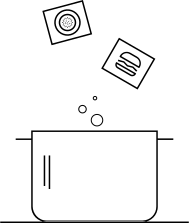
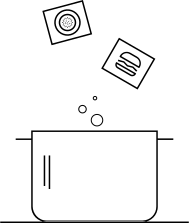
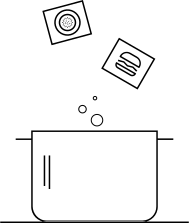
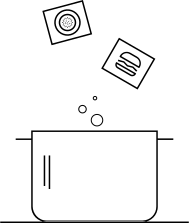
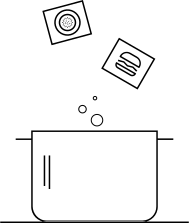
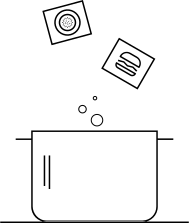

In [45]:
for j in range(1):
    linkers = CrawlerEda().get_links(700, 1000)
    print(len(linkers))
    for i in linkers:
        DBHelper().insert("link", "id", [i.id, i.link, i.photo])